In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl

# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

### Real Data Example

In [2]:
projections = bt.ArrayList(
        [[1,0], [0,1], [1, 1], [1, -1], [1, 1j], [1,-1j]], 
        names=list('HVDARL')
    ).normalize()
basis = (projections.reshape((2,1)) * projections.dagger()).kron_power(2)
basis

In [3]:
counts = np.array([
        [40230,150,19970,20533,21900,18910],
        [220,39094,18542,20050,18003,21054],
        [20556,19706,333,39918,20475,19975],
        [20010,18629,38011,440,18931,19544],
        [19900,19649,17423,21755,38717,401],
        [20761,19330,21207,18804,483,39382]
    ])

In [25]:
[a+b for a,b in itertools.product('HV','AB')]

['HA', 'HB', 'VA', 'VB']

In [31]:
import itertools
def group_idxs(pair1, pair2, include_extra=False):
    combinations = [a+b for a,b in itertools.product(pair1, pair2)]
    return [
        ((idx, data.counts[idx], name) if include_extra else idx)
        for idx, name in enumerate(basis.names) 
        if name in combinations
    ]
groups = [group_idxs(a, b) for a,b in itertools.product(['HV', 'DA', 'RL'],repeat=2)]
[group_idxs(a, b, include_extra=True) for a,b in itertools.product(['HV', 'DA', 'RL'],repeat=2)]

[[(0, 40230, 'HH'), (1, 150, 'HV'), (6, 220, 'VH'), (7, 39094, 'VV')],
 [(2, 19970, 'HD'), (3, 20533, 'HA'), (8, 18542, 'VD'), (9, 20050, 'VA')],
 [(4, 21900, 'HR'), (5, 18910, 'HL'), (10, 18003, 'VR'), (11, 21054, 'VL')],
 [(12, 20556, 'DH'), (13, 19706, 'DV'), (18, 20010, 'AH'), (19, 18629, 'AV')],
 [(14, 333, 'DD'), (15, 39918, 'DA'), (20, 38011, 'AD'), (21, 440, 'AA')],
 [(16, 20475, 'DR'), (17, 19975, 'DL'), (22, 18931, 'AR'), (23, 19544, 'AL')],
 [(24, 19900, 'RH'), (25, 19649, 'RV'), (30, 20761, 'LH'), (31, 19330, 'LV')],
 [(26, 17423, 'RD'), (27, 21755, 'RA'), (32, 21207, 'LD'), (33, 18804, 'LA')],
 [(28, 38717, 'RR'), (29, 401, 'RL'), (34, 483, 'LR'), (35, 39382, 'LL')]]

In [33]:
groups

[[0, 1, 6, 7],
 [2, 3, 8, 9],
 [4, 5, 10, 11],
 [12, 13, 18, 19],
 [14, 15, 20, 21],
 [16, 17, 22, 23],
 [24, 25, 30, 31],
 [26, 27, 32, 33],
 [28, 29, 34, 35]]

In [19]:
basis[14]

In [38]:
data = bt.PoissonTomographyData(basis, counts.flatten(), groups=groups)
sampler = bt.PoissonGinibreStateSampler(n_chains=32)
posterior = bt.StatePosterior(sampler, data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6693b817e5b96769ef2824ec1fde5ffd NOW.


In [39]:
psi = np.array([[1],[0],[0],[-1]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

In [35]:
['{} += {}'.format(a,b) for a,b in zip(np.sum(data.counts[data.groups],axis=-1), np.sqrt(np.sum(data.counts[data.groups],axis=-1)))]

['79694 += 282.3012575246522',
 '79095 += 281.238333091348',
 '79867 += 282.6075016697186',
 '78901 += 280.8932181452589',
 '78702 += 280.5387673744932',
 '78925 += 280.9359357576029',
 '79640 += 282.20559881051264',
 '79189 += 281.4054015117691',
 '78983 += 281.03914318115903']

In [40]:
posterior.fit_object

/home/ihincks/.miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/ihincks/.miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Inference for Stan model: anon_model_6693b817e5b96769ef2824ec1fde5ffd.
32 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=8000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X_real[0,0]    -0.07    0.32   1.27  -3.52  -0.63-2.4e-5   0.69    2.1     16  91.32
X_real[1,0]   7.3e-3    0.02   0.08  -0.13  -0.06 7.6e-3   0.06   0.17     16  71.86
X_real[2,0]     0.01    0.03   0.11  -0.26  -0.06   0.02   0.07    0.2     16  58.43
X_real[3,0]      0.1    0.31   1.23  -2.19  -0.61   0.18   0.69   3.38     16  88.67
X_real[0,1]    -0.16    0.38   1.54  -2.64  -1.57  -0.36   1.45   2.76     16   90.4
X_real[1,1]  -6.2e-3    0.02   0.08  -0.16  -0.07  -0.02   0.05   0.19     16  66.74
X_real[2,1]    -0.01    0.03    0.1  -0.17   -0.1  -0.04   0.08   0.17     16  75.14
X_real[3,1]     0.13    0.37   1.47  -2.17  -1.27   0.16   1.38   2.65     16   84.7
X_real[0,2]     0.18    0.31   1.23  -2.03  -0.4

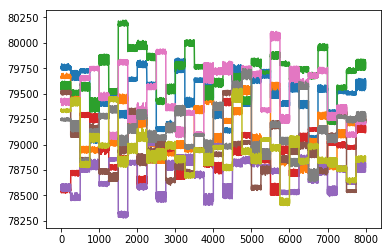

In [41]:
#plt.plot(posterior.fit_object['flux'] + 100)
plt.plot(posterior.fit_object['group_flux'])

Text(0.5,0,'Posterior of flux')

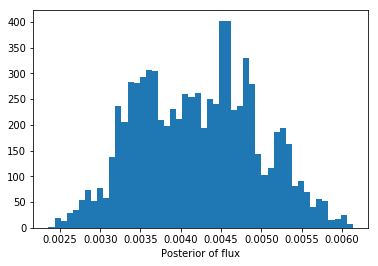

In [42]:
plt.hist(posterior.fit_object['rho_real'][:,-3,3],50)
plt.xlabel('Posterior of flux')

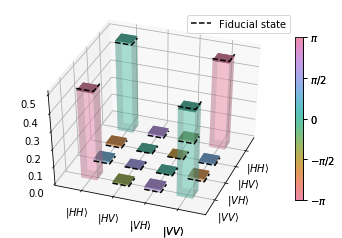

In [43]:
vector_basis = bt.canonical_basis([2])
vector_basis._names = ['H', 'V']
vector_basis=vector_basis.kron_power(2)
posterior.plot_matrix(vector_basis=vector_basis)
posterior.plot_matrix(fiducial_state=rho, vector_basis=vector_basis)

(0.9725, 0.99)

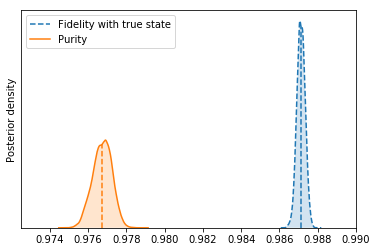

In [11]:
posterior.plot_fidelity(rho, label='Fidelity with true state', ls='--')
posterior.plot_purity(label='Purity')
plt.xlabel('')
plt.legend()
plt.xlim([0.9725,0.99])

### Single Qubit Example

Define the 'true' state before we begin:

In [2]:
psi = np.array([[1],[1j]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

We will be performing the following measurements:

In [3]:
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
meas_ops

Simulate some data based off of the true state using binomial statistics with 500 shots per measurement operator:

In [4]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, [5000,5000,5000])
print('measurement results: {}'.format(data.results))

measurement results: [2474 5000 2573]


Now we can construct an MCMC sampler with a Ginibre (K=2) prior, and feed this and the data in to get samples from a posterior.

In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2, n_chains=4)
posterior = bt.StatePosterior(sampler, data)

Make some plots of the resulting posterior:

(2, 4)


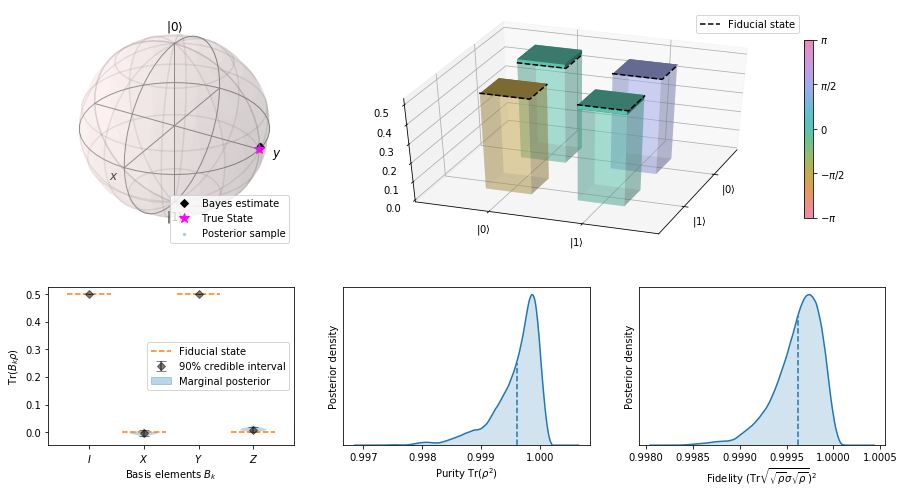

In [6]:
fig = plt.figure(figsize=(15, 8))
gs = mpl.gridspec.GridSpec(2,3, height_ratios=[3,2])

ax_bloch = plt.subplot(gs[0,0], projection='3d')
posterior.plot_bloch(axes=ax_bloch, fiducial_state=rho, fiducial_state_kwargs={'label': 'True State'})

ax_mat = plt.subplot(gs[0,1:3], projection='3d')
posterior.plot_matrix(axes=ax_mat, fiducial_state=rho)

ax_be = plt.subplot(gs[1,0])
posterior.plot_basis_expansion(bt.pauli_basis(), fiducial_state=rho)

ax_purity = plt.subplot(gs[1,1])
posterior.plot_purity()

ax_fidelity = plt.subplot(gs[1,2])
posterior.plot_fidelity(rho)

### Two Qubit Example

Everything is basically the same as above. We use the cat state as our true state, and we measure 15 combinations of Paulis offset by the identity.

In [7]:
psi = np.array([[1],[0],[0],[1]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis() + np.eye(2))/2
meas_ops = meas_ops.kron(meas_ops)[1:]

Generate the data with binomial sampling at 500 shots per measurement operator.

In [8]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 5000)
print('measurement results: {}'.format(data.results))

measurement results: [2443 2523 2517 2489 2560 1280 1293 2505 1289    0 1219 2508 1295 1217
 2562]


Define the sampler and draw posterior samples.

In [9]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

In [10]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

Now let's make a few plots:

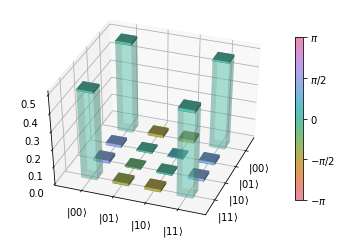

In [11]:
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2]))

(2, 16)


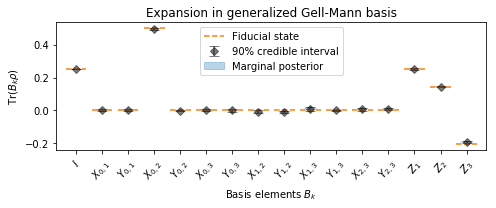

In [12]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.gell_mann_basis(4), fiducial_state=rho)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=50) # rotate tick labels
plt.title('Expansion in generalized Gell-Mann basis')
plt.tight_layout()

(2, 16)


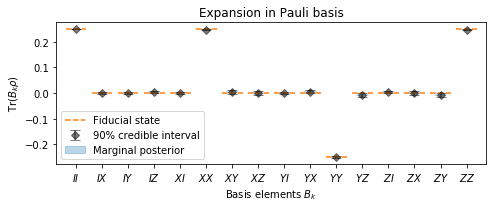

In [13]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.pauli_basis(2), fiducial_state=rho)
plt.title('Expansion in Pauli basis')
plt.tight_layout()

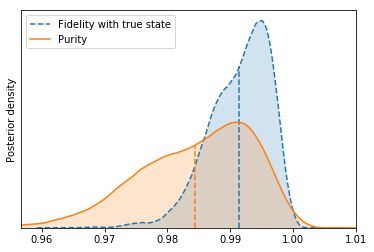

In [14]:
posterior.plot_fidelity(rho, label='Fidelity with true state', ls='--')
posterior.plot_purity(label='Purity')
plt.xlabel('')
plt.legend()

### Four qubit example

In [12]:
n_qubits = 4
psi = np.zeros((2**n_qubits,1), dtype=np.complex)
psi[[0,-1]] = 1 / np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis(n_qubits)[1:] + np.eye(psi.size)) / 2

In [13]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 50000)
print('measurement results: {}'.format(data.results))

measurement results: [24843 25054 24876 25064 24981 25100 24986 25050 25030 24873 24837 25055
 24855 24946 50000 25127 24934 25063 24847 25041 25197 24922 24826 24951
 25038 25043 25127 24885 24939 25055 25220 25076 25044 25130 25116 25043
 25007 24950 25059 24936 24979 25130 24918 25109 24977 24884 25232 25060
 25093 25005 50000 24931 24999 24874 24842 24931 25084 24882 24916 50000
 24946 25079 25055 24967 24922 24903 25015 24912 24885 24912 25096 24953
 25015 25056 25056 24990 24967 25082 25081 24858 25004 24919 25071 25171
 50000 24840 24842 25174 25003     0 25001 24720 25166 25107 24874 24911
 25054 25014 25047 24974 24838     0 24953 25187     0 24945 25072 25110
 25075 24915 24912 24942 25017 24932 25036 25123 24858 25099 24956 24875
 25052 24877 25055 25177 25048 25349 24896 25013 25162 24773 24888 25091
 25159 24884 25168 25038 24847 24979 25026 25149 25181 25016 24797 25091
 24934 25054 24952 25171 25050     0 25046 24900     0 24895 25121 24928
 24896 25076 24936 24864 24867

In [14]:
import statsmodels.api as sm
def mle(self):
    basis = bt.gell_mann_basis(self.dim, normalize=True)
    X = np.real(basis.expansion(self.meas_ops).T)
    
    # estimate of each measurement's overlap with the state
    y = (self.results + 0.5) / (self.n_shots + 1)
    
    # std of each estimate
    w = np.sqrt(y * (1 - y) / self.n_shots)
    
    y /= w
    X = X / w[:,np.newaxis]
    
    # we assume unit trace density matrices, thus we know coeff on this
    # basis element is 1/sqrt(d). thus, subtract it off the RHS to 
    # avoid making it a fit parameter.
    y -= X[:,0] / np.sqrt(self.dim)
    X = X[:,1:]
    
    %timeit np.linalg.lstsq(X,y,rcond=None)[0]
    %timeit np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
mle(data)

5.31 ms ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.16 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=1, n_iter=2000)
posterior = bt.StatePosterior(sampler, data)

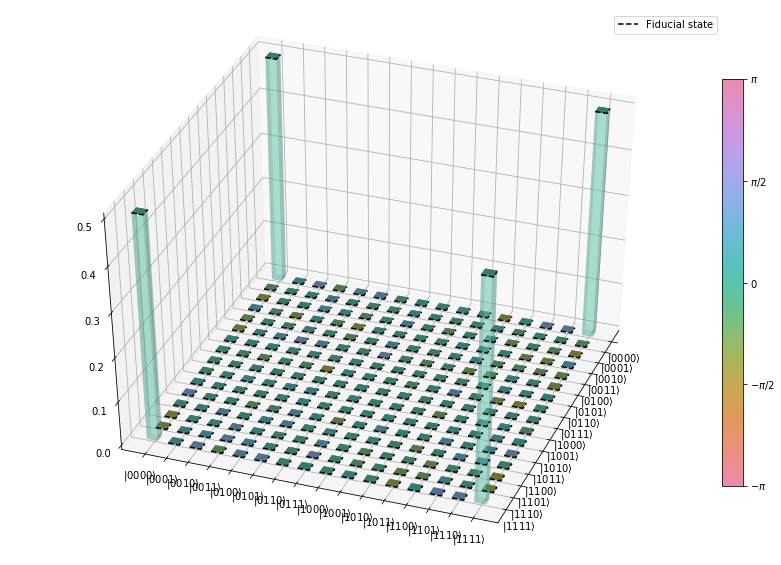

In [129]:
fig = plt.figure(figsize=(15,10))
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2,2,2]), fiducial_state=rho)